In [6]:

from nanodet.util import cfg, load_config, Logger
import cv2
import numpy as np
import torch
import os
import os.path as osp
from ultralytics import YOLO

from torchvision.ops import nms
import math
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from ultralytics.nn.modules.head import Detect
import torch.nn as nn
import coremltools as ct
from demo.demo import Predictor

def normalize(img, mean, std):
    mean = np.array(mean, dtype=np.float32).reshape(1, 1, 3) / 255
    std = np.array(std, dtype=np.float32).reshape(1, 1, 3) / 255
    img = (img - mean) / std    
    return img

def distance2bbox(points, distance, max_shape=None):
    """Decode distance prediction to bounding box.

    Args:
        points (Tensor): Shape (n, 2), [x, y].
        distance (Tensor): Distance from the given point to 4
            boundaries (left, top, right, bottom).
        max_shape (tuple): Shape of the image.

    Returns:
        Tensor: Decoded bboxes.
    """
    x1 = points[..., 0] - distance[..., 0]
    y1 = points[..., 1] - distance[..., 1]
    x2 = points[..., 0] + distance[..., 2]
    y2 = points[..., 1] + distance[..., 3]
    if max_shape is not None:
        x1 = x1.clamp(min=0, max=max_shape[1])
        y1 = y1.clamp(min=0, max=max_shape[0])
        x2 = x2.clamp(min=0, max=max_shape[1])
        y2 = y2.clamp(min=0, max=max_shape[0])
    return torch.stack([x1, y1, x2, y2], -1)

def pre_process(img_path):# -> Any:
    norm = [[103.53, 116.28, 123.675], [57.375, 57.12, 58.395]]
    img = cv2.imread(img_path).astype(np.float32) / 255
    img = normalize(img, *norm)
    return img

def warp_boxes(boxes, M, width, height):
    n = len(boxes)
    if n:
        # warp points
        xy = torch.ones((n * 4, 3))
        xy[:, :2] = boxes[:, [0, 1, 2, 3, 0, 3, 2, 1]].reshape(
            n * 4, 2
        )  # x1y1, x2y2, x1y2, x2y1
        xy = xy @ M.T  # transform
        xy = (xy[:, :2] / xy[:, 2:3]).reshape(n, 8)  # rescale
        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = torch.stack((x.min(dim=1).values, y.min(dim=1).values, x.max(dim=1).values, y.max(dim=1).values)).T
        # clip boxes
        xy[:, [0, 2]] = xy[:, [0, 2]].clamp(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clamp(0, height)
        return xy.to(torch.float32)
    else:
        return boxes

In [7]:
class IOSDetectModel(torch.nn.Module):
    def __init__(self, model, im: torch.Tensor):
        super().__init__()
        self.model = model
        self.nc = 2
        self.device = torch.device('cpu')
        # self.mean = torch.Tensor([0.406, 0.456, 0.485]).view(1,3,1,1)
        # self.std = torch.Tensor([0.225, 0.224, 0.229]).view(1,3,1,1)
        self.reg_max = 7
    def forward(self, x):
        x = x[:, [2,1,0], :, :]
        # x = (x-self.mean)/self.std
        preds = self.model(x)
        cls_preds, reg_preds = preds.split(
            [3, 32], dim=-1
        )
        b = cls_preds.shape[0]
        input_height, input_width = 640, 640
        input_shape = (input_height, input_width)
        strides = [8.0, 16.0, 32.0, 64.0]
        featmap_sizes = [
            (input_height / stride, input_width / stride)
            for stride in strides
        ]
        # tính center của các anchor box, có tổng cộng 4 loại anchor box 
        mlvl_center_priors = [
            self.model.head.get_single_level_center_priors(
                    b,
                    featmap_sizes[i],
                    stride,
                    dtype=torch.float16,
                    device=self.device,
                )
            for i, stride in enumerate(strides)
        ]
        center_priors = torch.cat(mlvl_center_priors, dim=1).to(torch.float16)
        shape = reg_preds.size()
        reg_preds_softmax = F.softmax(reg_preds.reshape(*shape[:-1], 4, self.reg_max + 1), dim=-1)
        project = torch.linspace(0, self.reg_max, self.reg_max + 1).reshape(-1,1)
        dis_preds = (reg_preds_softmax@project).squeeze(-1) * center_priors[..., 2, None]
        bboxes = distance2bbox(center_priors[..., :2], dis_preds, max_shape=input_shape)
        scores = cls_preds.sigmoid()[:,:,1:]
        width = bboxes[:, :, 2] - bboxes[:, :, 0]
        height = bboxes[:, :, 3] - bboxes[:, :, 1]
        x_center = bboxes[:, :, 0] + width/2
        y_center = bboxes [:, :, 1] + height/2
        xywh = torch.stack((x_center/input_width, y_center/input_height, width/input_width, height/input_height), axis=2)
        return  scores[0], xywh[0]

In [8]:
config_path = 'plus640.yml'
model_path = 'savedir640/model_best/nanodet_model_best.pth'
image_path = 'orangecoco2/test/31_jpg.rf.ec6c7173e054ce15fd8c7356352c564d.jpg'
device = torch.device('cpu')

load_config(cfg, config_path)
logger = Logger(-1, use_tensorboard=False)

predictor = Predictor(cfg, model_path, logger, device=device)
meta, res = predictor.inference(image_path)

model = predictor.model

img = torch.from_numpy(pre_process(image_path).transpose(2, 0, 1)).to(device).unsqueeze(0)


model size is  1.0x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.
(640, 640, 3)
forward time: 0.196s | {0: [], 1: [[237.24908447265625, 171.26834106445312, 601.1812744140625, 530.4403076171875, 0.9264985918998718], [37.149871826171875, 116.29776000976562, 320.48980712890625, 442.1055908203125, 0.778769850730896], [261.3868103027344, 46.416542053222656, 526.6712036132812, 190.12472534179688, 0.3648466169834137], [256.21026611328125, 22.978347778320312, 589.8133544921875, 221.90960693359375, 0.12282201647758484], [38.92317199707031, 128.63070678710938, 212.23667907714844, 435.5875244140625, 0.06485205888748169], [325.17779541015625, 44.42021179199219, 478.5195617675781, 180.9714813232422, 0.056583281606435776], [39.613128662109375, 347.7638244628906, 454.7862243652344, 593.5345458984375, 0.053804438561201096], [0.0, 345.468505859375, 334.4940185546875, 640.0, 0.053232721984386444], [62.3

In [9]:
im = torch.from_numpy(np.array(Image.open(image_path))).permute(2,0,1).unsqueeze(0).float()/255

iosmodel = IOSDetectModel(model=model, im=im)
iosmodel.eval()

IOSDetectModel(
  (model): NanoDetPlus(
    (backbone): ShuffleNetV2(
      (conv1): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (stage2): Sequential(
        (0): ShuffleV2Block(
          (branch1): Sequential(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
            (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): LeakyReLU(negative_slope=0.1, inplace=True)
          )
          (branch2): 

In [10]:
res = iosmodel.forward(im)

In [12]:
res[0]

tensor([[0.0051, 0.0033],
        [0.0056, 0.0040],
        [0.0045, 0.0036],
        ...,
        [0.0219, 0.0035],
        [0.0257, 0.0047],
        [0.0177, 0.0068]], grad_fn=<SelectBackward0>)

In [13]:
imgg = np.array(Image.open(image_path))
imgg.shape

(640, 640, 3)

In [14]:
bboxes = res[1].detach().cpu().numpy()
bboxes

array([[   0.025364,    0.026538,    0.050728,    0.053076],
       [   0.024911,    0.022803,    0.049822,    0.045607],
       [   0.032185,    0.018411,     0.06437,    0.036822],
       ...,
       [     0.6443,     0.85624,     0.71141,     0.28751],
       [    0.70009,     0.85228,     0.59982,     0.29544],
       [    0.75796,     0.82207,     0.48408,     0.35587]], dtype=float32)

In [15]:
# width = bboxes[:, 2] - bboxes[:, 0]
# height = bboxes[:, 3] - bboxes[:, 1]

# x_center = bboxes[:, 0] + width /2
# y_center = bboxes[:, 1] + width /2

# bbox_xywh = np.stack((x_center, y_center, width, height), axis=1)

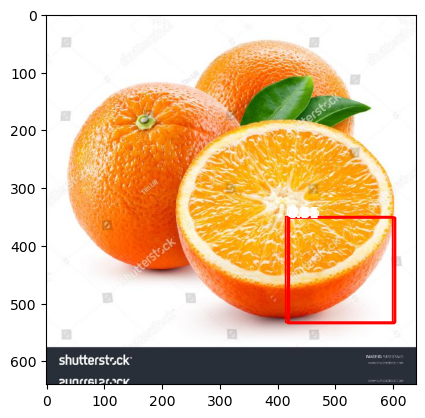

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the image
bboxes = res[1].detach().cpu().numpy()
confidences = res[0][:, 0].detach().cpu().numpy()  # assuming you want the first column

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
imgg = np.array(Image.open(image_path))
img = imgg
# ax.imshow(img[0].permute(1,2,0).detach().cpu().numpy())
ax.imshow(img)
# For each bounding box
for bbox, confidence in zip(bboxes, confidences):
    # Convert from xywh to xyxy in image space
    x1, y1, w, h = bbox*640
    if confidence < 0.8:
        continue
    # x1, y1, x2, y2 = bbox
    # w, h = x2 - x1, y2 - y1

    # Create a Rectangle patch
    rect = patches.Rectangle((x1, y1), w/2, h/2, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Optionally add the confidence as text
    plt.text(x1, y1, f"{confidence:.2f}", color='white')

plt.show()

In [34]:
ct_test_model = ct.models.MLModel('orangeyolo.mlpackage')

In [38]:
res_ct = ct_test_model.predict({"image": Image.open('test.jpg')})

In [40]:
res_ct['coordinates']*640

array([[        395,      331.56,      240.47,      156.09],
       [     219.22,      446.56,      163.59,      238.44],
       [     256.72,      126.02,       237.5,      208.44]], dtype=float32)

395.0 331.5625 240.46875 156.09375
219.21875 446.5625 163.59375 238.4375
256.71875 126.015625 237.5 208.4375


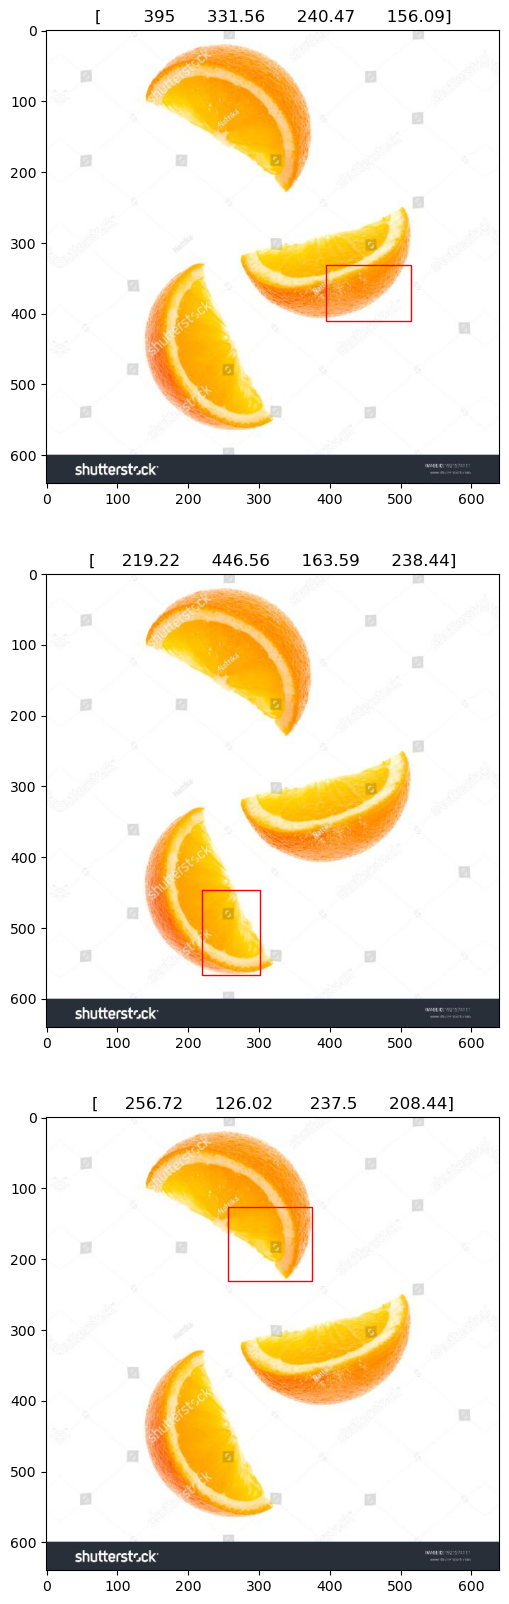

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the image
fig, ax = plt.subplots(3,1, figsize=(60,20))

# Display the image

bboxes = res_ct['coordinates']*640
confidences = res_ct['confidence']  # assuming you want the first column

# For each bounding box
for i, (bbox, confidence) in enumerate(zip(bboxes, confidences)):
    ax[i].imshow(Image.open('test.jpg'))
    # Convert from xywh to xyxy in image space
    x, y, w, h = bbox
    print(x,y,w,h)

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w/2, h/2, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax[i].add_patch(rect)

    # Optionally add the confidence as text
    ax[i].set_title(bbox)

plt.show()

In [51]:
ts = torch.jit.optimize_for_inference(torch.jit.trace(iosmodel.eval(), im,strict=False))

In [13]:
torch.jit.save(ts, 'nanodet.jit.ts')

In [52]:
MODEL_PATH='orangenanodet.mlpackage'
CLASSES = {0: 'fresh orange', 1: 'rotten orange'}
SCALE = 1/(0.226*255.0)
BIAS = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

ct_model = ct.convert(ts,
                      inputs=[ct.ImageType('image', shape=im.shape, scale=SCALE, bias=BIAS)],
                      classifier_config=None,
                      convert_to='mlprogram',
                      compute_precision=ct.precision.FLOAT16)
ct_model.save(MODEL_PATH)
weights_dir = str(osp.join(MODEL_PATH, 'Data/com.apple.CoreML/weights'))

[coremltools][12-10 07:30:27]WARNING:Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
[coremltools][12-10 07:30:27]WARNING:Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
[coremltools][12-10 07:30:27]WARNING:Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
[coremltools][12-10 07:30:27]WARNING:Support for converting Torch Script Models is experimental. If possible you should use a traced model for conversion.
[coremltools][12-10 07:30:27]WARNING:Tuple detected at graph output. This will be flattened in the converted model.
[coremltools][12-10 07:30:27]WARNING:Tuple detected at graph output. This will be flattened in the converted model.
[coremltools][12-10 07:30:27]WARNING:Tuple detected at graph output. This will be flattened in the converted model.
[coremltools][12-10 07:30:27]WAR

In [54]:
from coremltools.models.neural_network import quantization_utils

ct_model = quantization_utils.quantize_weights(ct_model, 16, weights_dir=weights_dir)

Quantizing using linear quantization


Exception: MLModel of type mlProgram cannot be loaded just from the model spec object. It also needs the path to the weights file. Please provide that as well, using the 'weights_dir' argument.

In [58]:
dir(ct.models.datatypes)

['Array',
 'Dictionary',
 'Double',
 'Int64',
 'Model_pb2',
 'String',
 '_DatatypeBase',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_is_valid_datatype',
 '_normalize_datatype',
 '_np',
 '_set_datatype',
 '_simple_type_remap']

In [55]:
spec = ct_model.get_spec()
out0, out1 = iter(spec.description.output)
out0_shape = out0.type.multiArrayType.shape
out1_shape = out1.type.multiArrayType.shape

nx, ny = spec.description.input[0].type.imageType.width, spec.description.input[0].type.imageType.height
_, nc = out0_shape

cm_from_spec = ct.models.MLModel(spec, weights_dir=weights_dir)
nms_spec = ct.proto.Model_pb2.Model()
nms_spec.specificationVersion = 5
for i in range(2):
    decoder_output = cm_from_spec._spec.description.output[i].SerializeToString()
    nms_spec.description.input.add()
    nms_spec.description.input[i].ParseFromString(decoder_output)
    nms_spec.description.output.add()
    nms_spec.description.output[i].ParseFromString(decoder_output)

nms_spec.description.output[0].name = 'confidence'
nms_spec.description.output[1].name = 'coordinates'

output_sizes = [nc, 4]
for i in range(2):
    ma_type = nms_spec.description.output[i].type.multiArrayType
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[0].lowerBound = 0
    ma_type.shapeRange.sizeRanges[0].upperBound = -1
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
    ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
    del ma_type.shape[:]

nms = nms_spec.nonMaximumSuppression
nms.confidenceInputFeatureName = out0.name  # 1x507x80
nms.coordinatesInputFeatureName = out1.name  # 1x507x4
nms.confidenceOutputFeatureName = 'confidence'
nms.coordinatesOutputFeatureName = 'coordinates'
nms.iouThresholdInputFeatureName = 'iouThreshold'
nms.confidenceThresholdInputFeatureName = 'confidenceThreshold'
nms.iouThreshold = 0.45
nms.confidenceThreshold = 0.25
nms.pickTop.perClass = True
nms.stringClassLabels.vector.extend(CLASSES.values())
nms_model = ct.models.MLModel(nms_spec)

# 4. Pipeline models together
pipeline = ct.models.pipeline.Pipeline(input_features=[('image', ct.models.datatypes.Array(3, ny, nx)),
                                                       ('iouThreshold', ct.models.datatypes.Double()),
                                                       ('confidenceThreshold', ct.models.datatypes.Double())],
                                       output_features=['confidence', 'coordinates'])
pipeline.add_model(cm_from_spec)
pipeline.add_model(nms_model)

# Correct datatypes
pipeline.spec.description.input[0].ParseFromString(cm_from_spec._spec.description.input[0].SerializeToString())
pipeline.spec.description.output[0].ParseFromString(nms_model._spec.description.output[0].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(nms_model._spec.description.output[1].SerializeToString())

# Update metadata
pipeline.spec.specificationVersion = 5
pipeline.spec.description.metadata.userDefined.update({
    'IoU threshold': str(nms.iouThreshold),
    'Confidence threshold': str(nms.confidenceThreshold)})

# Save the model
model_from_pipeline_spec = ct.models.MLModel(pipeline.spec, weights_dir=weights_dir)
model_from_pipeline_spec.input_description['image'] = 'Input image'
model_from_pipeline_spec.input_description['iouThreshold'] = f'(optional) IOU threshold override (default: {nms.iouThreshold})'
model_from_pipeline_spec.input_description['confidenceThreshold'] = \
    f'(optional) Confidence threshold override (default: {nms.confidenceThreshold})'
model_from_pipeline_spec.output_description['confidence'] = 'Boxes × Class confidence (see user-defined metadata "classes")'
model_from_pipeline_spec.output_description['coordinates'] = 'Boxes × [x, y, width, height] (relative to image size)'


In [56]:
model_from_pipeline_spec.predict({"image": Image.open(image_path)})

{'coordinates': array([[    0.65479,     0.54834,     0.56885,     0.56152],
        [    0.27734,     0.43628,     0.43848,     0.50879],
        [    0.61572,     0.18506,     0.41821,     0.22571]], dtype=float32),
 'confidence': array([[    0.92676,    0.014648],
        [    0.77441,    0.067383],
        [    0.33008,   0.0068359]], dtype=float32)}

In [57]:
model_from_pipeline_spec.save(MODEL_PATH)